# Draft data processing

## To do

- [x] Load data
- [x] Homography

#### Data cleaning

 - [ ] Define areas in worldview plane
 - [ ] Reproject areas to video plae
 - [ ] Filter trajectories based on areas
 - [ ] Clean trajectories (How?). Iterpolation, remove outliers (e.g. points outside path)
 
#### Inference
 - [ ] Calculate speed

## Settings

In [110]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px


import os
import copy as cp

In [2]:
# Import custom functions 
# from utils import *

from modules.utils import *
from modules.draw import *
from modules.homography import PixelMapper

In [3]:

# PLotting params
plt.rcParams['figure.figsize'] = [15, 10]


Functions (move this somewhere else eventually)

In [4]:
# Plot inline function for one ore two images
def imgshow(img, img2 = None):
    if img2 is None:
        plt.imshow(img)
        # plt.title('World view')
        plt.show()
    else:
        plt.subplot(1, 2, 1)
        plt.imshow(img)


        plt.subplot(1, 2, 2)
        plt.imshow(img2)

        plt.tight_layout()

        plt.show()

        
# Homography plot functions
def draw_point(img, point, color, label = None):
    img_cp = cp.deepcopy(img)
    pcoords = tuple(point)
    cv2.circle(img_cp, pcoords, 4, color, -1)
    if label is not None:
        tcoords = tuple(point + 5)
        cv2.putText(img_cp, label, tcoords,  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    # ishow(img_cp)
    return img_cp


def draw_hom_points(img, points_array):
    img_cp = cp.deepcopy(img)
    # Loop over points
    i = 0
    for p in points_array:
        i += 1
        label = 'p' + str(i)
        img_cp = draw_point(img_cp, p, (0, 0, 255), label)
    return img_cp


## Load data

Load tabular data outputed by video-processing model

In [5]:
os.listdir('data')

['2-frame.jpg', '2-sample-30min.csv', '2-sat.jpg']

In [6]:
df = pd.read_csv('data/2-sample-30min.csv')

# Calculate centroids
df['cx'] =  round(df['xi'] + (df['xj'] - df['xi'])/2).astype(int)
df['cy'] =  round(df['yi'] + (df['yj'] - df['yi'])/2).astype(int)


Load images data

In [28]:
img_frame = cv2.imread('data/2-frame.jpg')
img_world = cv2.imread('data/2-sat.jpg')


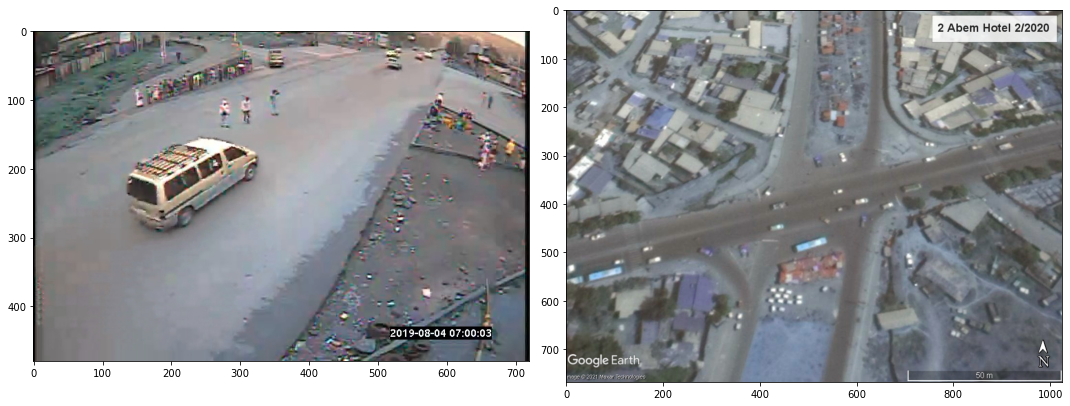

In [8]:
imgshow(img_frame, img_world)

In [9]:
img_frame.shape

(480, 720, 3)

## Homography

Homography points defintion: Set the same points in both images and coordinates

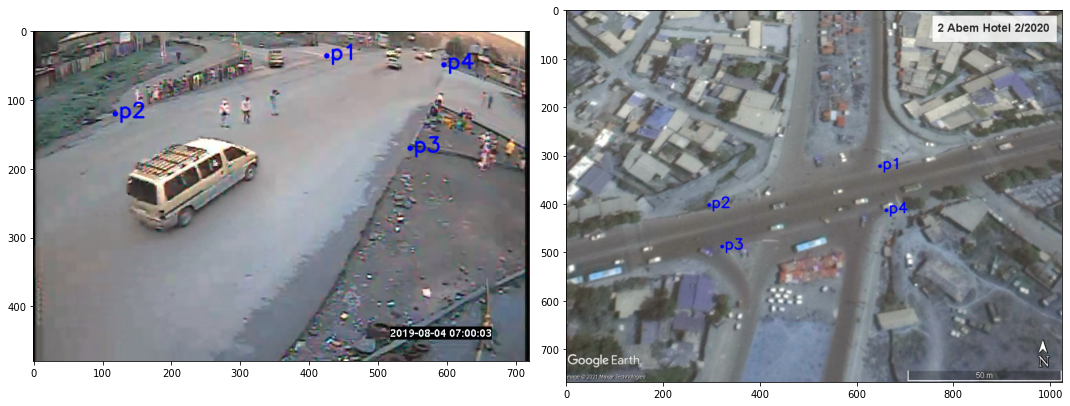

In [10]:
# Create one instance of PixelMapper to convert video frames to coordinates
quad_coords = {
    # Check these!
    "lonlat": np.array([
        [9.035947, 38.853956], # P1 top right
        [9.035794, 38.853338], # P2 top left
        [9.035631, 38.853425], # P3 bottom left
        [9.035782, 38.853971] #  P4 bottom right
    ]),
    "pixel": np.array([
        [426, 37], #  P1 top right
        [119, 121], #  P2 top left
        [547, 171], # P3 bottom left
        [596, 50] # P4 bottom right
    ]),
    "pixel_sat": np.array([
        [648, 322], # P1 top right
        [295, 402], # P2 top left
        [322, 488], #  P3 bottom left
        [661, 413] # P4 bottom right
    ])
}

# Display image points. 
img_s_points = draw_hom_points(img_world, quad_coords['pixel_sat'])
img_f_points = draw_hom_points(img_frame, quad_coords['pixel'])
imgshow(img_f_points, img_s_points)

PixelMapper class converts coordinates in pixels to lat-long

In [11]:
# Create pixel maper instance to convert from video to lat long (and vice versa)
pm = PixelMapper(quad_coords["pixel"], quad_coords["lonlat"])

# Create pixel maper instance to convert from sat image to lat long (and vice versa)
pm_sat = PixelMapper(quad_coords["pixel_sat"], quad_coords["lonlat"])

Test trajectory to see if homography is working:

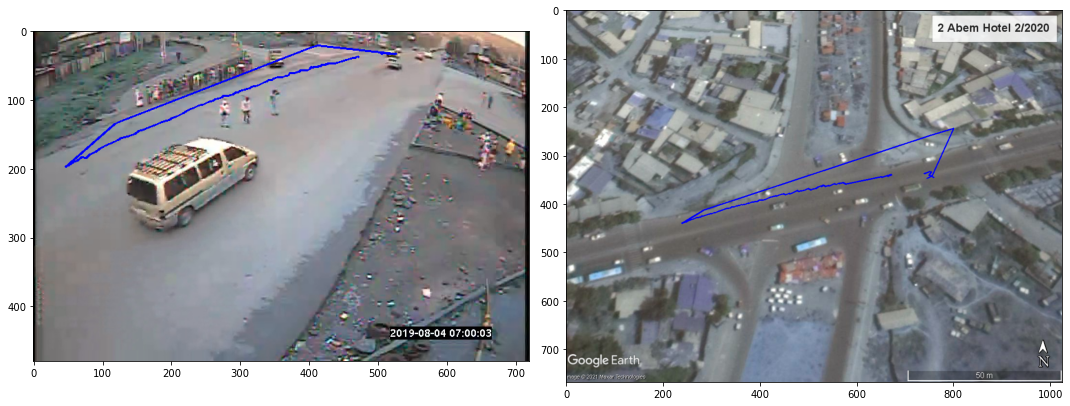

In [12]:
# To do
# - Make sure trajectories are in frame order
# - Organize this into a function



def draw_trajectory(img, trajectory_array, color):
    img_cp = cp.deepcopy(img)
    for p in range(1, len(trajectory_array)):
            cv2.line(img_cp, tuple(trajectory_array[p-1]), tuple(trajectory_array[p]), color, 2)
    return img_cp


# Create trajectory df
car_df = df[df['obj_id'] == 15]

t_car = car_df[['cx', 'cy']].to_numpy()

# Anotate trajectory on initial video frame
img_cf = img_frame.copy()
img_cf = draw_trajectory(img_cf, t_car, (0, 0, 255))

# # ishow(img_cf)

# Transform trajectories to long lat
t_car_ll = pm.pixel_to_lonlat(t_car) # t_car created in draft-intersections.py

# Transform lat long trajectory into pixels of sat image
t_car_s = pm_sat.lonlat_to_pixel(t_car_ll).astype(int)

# # Anotate trajectory on sat image
img_cs = img_world.copy()
img_cs = draw_trajectory(img_cs, t_car_s, (0, 0, 255))

imgshow(img_cf, img_cs)

In [13]:
car_df

frame   xi  yi   xj  yj  obj_id  class   cx  cy
64        7  462  28  483  48      15      2  472  38
75        8  462  30  481  48      15      2  472  39
87        9  462  30  481  48      15      2  472  39
99       10  460  30  480  47      15      2  470  38
110      11  459  29  480  48      15      2  470  38
...     ...  ...  ..  ...  ..     ...    ...  ...  ..
3458    326  490  20  522  47      15      2  506  34
3471    327  490  21  522  47      15      2  506  34
3482    328  489  20  521  47      15      2  505  34
3493    329  490  21  521  48      15      2  506  34
3505    330  489  21  521  48      15      2  505  34

[177 rows x 9 columns]

In [113]:
fig = px.scatter(car_df, x="cx", y="cy", text="frame", log_x=True, size_max=60)
fig.show()

In [ ]:
trajectory_array = t_car 
color = (0, 0, 255)
img_cp = cp.deepcopy(img_frame)

for p in range(1, len(trajectory_array)):
    cv2.line(img_cp, tuple(trajectory_array[p-1]), tuple(trajectory_array[p]), color, 2)
ishow(img_cp)

In [ ]:
# cv2.destroyAllWindows() 

## Path definition

Define preliminary east through movement

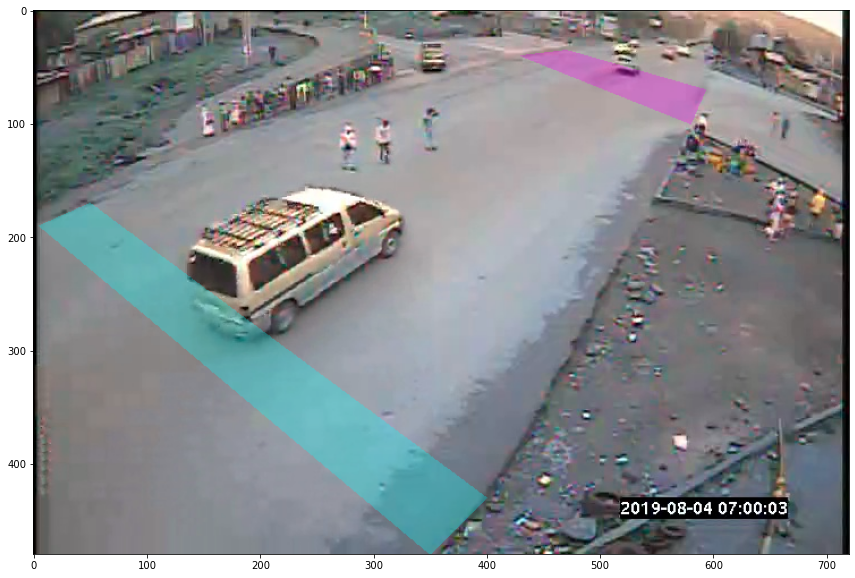

In [65]:
overlay = cp.deepcopy(img_frame)
image_new = cp.deepcopy(img_frame)

# x, y, w, h = 10, 10, 10, 10  # Rectangle parameters
# cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 200, 0), -1)  # A filled rectangle

# First trajectory area
contours1 = np.array([[5,190], # top left 
                     [350,480], # bottom left
                     [400,430], # bottom right
                     [50,170]]) # top right
# Second trajectory area
contours2 = np.array([[430,40], # top left 
                     [580,100], # bottom left
                     [593,70], # bottom right
                     [470,35]]) # top right


alpha = 0.3  # Transparency factor.
poly1 = cv2.fillPoly(overlay, pts = [contours1], color =(0,255,255))
poly2 = cv2.fillPoly(overlay, pts = [contours2], color =(255,0,255))


# Following line overlays transparent rectangle over the image
image_new = cv2.addWeighted(overlay, alpha, image_new, 1 - alpha, 0)

imgshow(image_new)

Filter only trajectories that match the movement (o try to)

In [77]:
# Test trajectory

trj_temp = df[df['obj_id'] == 15]; trj_temp

p_temp = tuple(trj_temp.iloc[2][['cx','cy']]); p_temp

(472, 39)

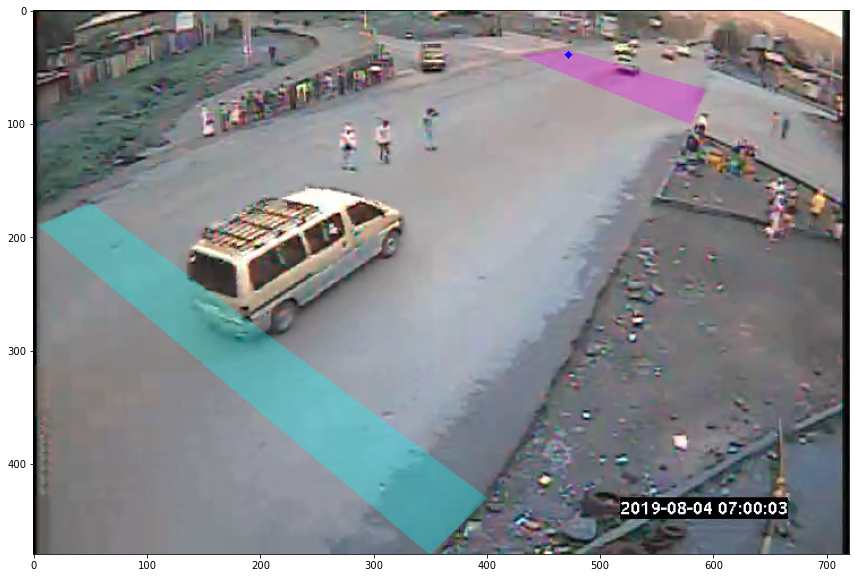

In [92]:
image_new_cp = cp.deepcopy(image_new)
cv2.circle(image_new_cp, tuple(p_temp), radius=1, color=(0, 0, 255), thickness=3)

imgshow(image_new_cp)

In [83]:
# Test if point in area
cv2.pointPolygonTest(contours2, p_temp, False) 

1.0

In [98]:
trj_temp

frame   xi  yi   xj  yj  obj_id  class   cx  cy
64        7  462  28  483  48      15      2  472  38
75        8  462  30  481  48      15      2  472  39
87        9  462  30  481  48      15      2  472  39
99       10  460  30  480  47      15      2  470  38
110      11  459  29  480  48      15      2  470  38
...     ...  ...  ..  ...  ..     ...    ...  ...  ..
3458    326  490  20  522  47      15      2  506  34
3471    327  490  21  522  47      15      2  506  34
3482    328  489  20  521  47      15      2  505  34
3493    329  490  21  521  48      15      2  506  34
3505    330  489  21  521  48      15      2  505  34

[177 rows x 9 columns]

In [106]:
foo = []
for i in range(0,10):
    foo.append(i)
foo

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [109]:

# Copy image to anotate with trajectory
image_new_cp = cp.deepcopy(image_new)

# Test each point individually. Try a more efficient way!


bol_area1 = []
bol_area2 = []

for i in range(0, len(obj_1)):
    p_i = tuple(trj_temp.iloc[i][['cx', 'cy']])
    
    # Test if points in area
    bol_area1.append(cv2.pointPolygonTest(contours1, p_i, False))
    bol_area2.append(cv2.pointPolygonTest(contours2, p_i, False))

    cv2.circle(image_new_cp, tuple(p_i), radius=1, color=(0, 0, 255), thickness=3)
#     print(p_i)
#     print(bol)

# Test if any point in area
any(bol_area1)

any(bol_area2)

True

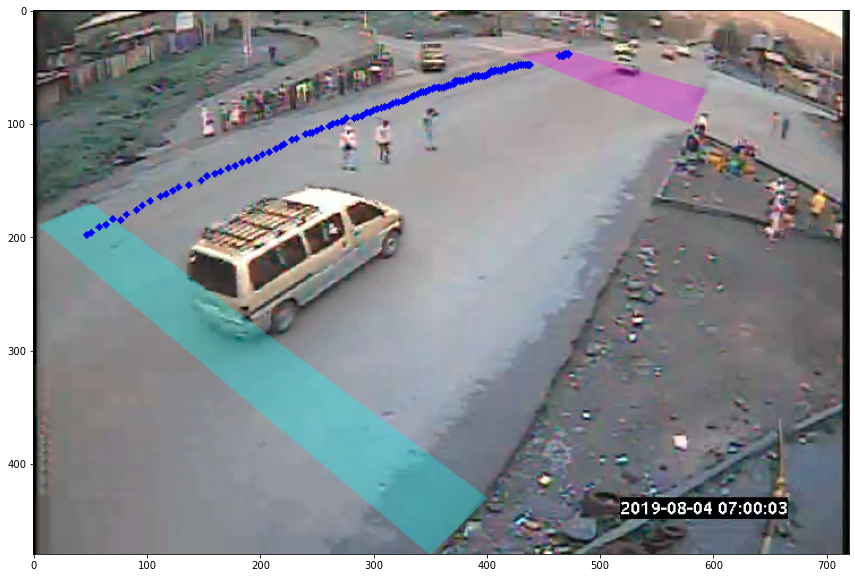

In [96]:
imgshow(image_new_cp)


In [ ]:
len(obj_1)

# DRAFT

In [ ]:
#----------------------------------------------------
# Use mouse to find points (or try to at least)


# Marker and grab position function

img = cp.deepcopy(img_frame)
mouseX,mouseY = 0,0

def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img,(x,y),3,(255,0,0),1)
        mouseX,mouseY = x,y
        

# A window that will capture the mouse click
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw_circle)

# while(1):
#     cv2.imshow('image',img)
#     # Kill window if Q is pressed
#     k = cv2.waitKey(1) & 0xFF
#     if k == ord('q'):
#         cv2.destroyAllWindows()
#         break
#     elif k == ord('a'):
#         print(mouseX,mouseY)
# print(mouseX,mouseY)